In [ ]:
###############################
#Script for creating plots of comparing DeepProfile enrichment 
# scores to VAE detections
###############################

from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
    


In [11]:
cancer_types = ['BRCA', 'AML', 
                'COLON', 'LUNG', 
                'BRAIN', 'OV', 
                'SARCOMA', 'KIDNEY', 
                'LIVER', 'STOMACH', 
                'SKIN', 'PROSTATE',
                'THYROID', 'UTERINE', 
                'HEAD_NECK', 'PANCREAS',
                'CERVICAL', 'BLADDER']

cancer_names = ['BREAST', 'AML',
                'COLORECTAL', 'LUNG',
                'BRAIN', 'OV', 
                'SARCOMA', 'KIDNEY', 
                'LIVER', 'STOMACH', 
                'MELANOMA', 'PROSTATE',
                'THYROID', 'UTERINE', 
                'HEAD&NECK', 'PANCREAS',
                'CERVICAL', 'BLADDER']

cancer_colors = ['#f19066', #BREAST = SAWTOOTH TANK
                 '#778beb', #AML = SOFT BLUE
                '#3dc1d3', #COLON = BLUE CHORACO
                 '#303952', #LUNG = BISCAY
                '#786fa6', #BRAIN = PURPLE MOUNTAIN
                 '#c44569', #OV = DEEP ROSE
                '#e77f67', #SARCOMA = BREWED MUSTARD
                 '#596275', #KIDNEY = PENCIL LEAD
                '#f5cd79', #LIVER = SUMMER TIME
                 '#546de5', #STOMACH = CORN FLOWER
                '#e15f41', #MELANOMA = TIGERLY
                 '#f7d794', #PROSTATE = ROSY HIGHLIGHT
                '#e66767', #THYROID = PORCELAIN ROSE
                 '#574b90', #UTERINE = PURPLE CORALLITE
                '#cf6a87', #HEADNECK = OLD GRENIUM
                 '#f3a683', #PANCREAS = CREAMY PEACH
                '#63cdda',  #CERVICAL = SQUEAKY
                 '#f8a5c2'] #BLADDER = ROGUE PINK


In [12]:
#Define method for creating plot
def createPlot(cancer_type, threshold = 100):
    
    input_folder = '../../ALL_CANCER_FILES/' + cancer_type + '/PATHWAY_FILES/'
   
    #Read pathway matrix
    pathway_df = pd.read_table(input_folder + 'PATHWAY_C2_MATRIX_INTERSECTION_GENES.tsv', index_col = 0)
    pathway_matrix = pathway_df.values
    print("Pathway matrix ", pathway_df.shape)

    #Read DeepProfile pathway coverages
    DP_df = pd.read_table(input_folder + cancer_type + 
                          '_FISHER_FDR_CORRECTED_PVALS_C2_DeepProfile_1.tsv', index_col = 0)
    print("P-values matrix ", DP_df.shape)

    #Read VAE model pathway coverages
    dims = [5, 10, 25, 50, 75, 100]
    VAE_pvals_list = []
    for dim in dims:
        for i in range(100):
            vae_df = pd.read_table(input_folder + cancer_type + '_FISHER_FDR_CORRECTED_PVALS_C2_VAE_' + str(dim) + 'L_' + str(i + 1) + '.tsv', index_col = 0)
            VAE_pvals_list.append(vae_df.values)

    #Now create a binary matrix which shows the p-vals for significant pathways
    VAE_matrix = np.zeros((600, pathway_df.shape[1]))
    DeepProfile_matrix = np.zeros(pathway_df.shape[1])

    for i in range(VAE_matrix.shape[0]):
        indices = np.where( VAE_pvals_list[i] < 0.05)[1]
        VAE_matrix[i, indices] = 1


    #Create smmary matrices
    VAE_matrix_summary = (np.sum(VAE_matrix, axis = 0) / 600) * 100
    indices = np.where(DP_df.values < 0.05)[1]
    DeepProfile_matrix[indices] = 1

    thresholds = np.arange(50, threshold, 10)
    percents_for_thresholds = []
    counts_for_VAEs = []
    counts_for_DeepProfile = []
    
    for threshold in thresholds:
        #print("Threshold ", threshold)
        VAE_indices = np.where(VAE_matrix_summary >= threshold)[0]
        DeepProfile_indices = np.where(DeepProfile_matrix == 1)[0]
        #print(VAE_indices)
        #print(DeepProfile_indices)
        common_indices = np.intersect1d(VAE_indices, DeepProfile_indices)
        #print(common_indices)
        #print(len(common_indices))

        #print("No of pathways captured by VAEs ", len(VAE_indices))
        #print("No of pathways captured by DeepProfile as well ", len(common_indices))
        if len(common_indices) == 0 and len(VAE_indices) == 0:
            final_ratio = 0
        else:
            final_ratio = (len(common_indices) / len(VAE_indices)) * 100
        #print("FINAL RATIO ", final_ratio)
        percents_for_thresholds.append(final_ratio)
        counts_for_DeepProfile.append(len(common_indices))
        counts_for_VAEs.append(len(VAE_indices))

    print("All final results ")
    print(percents_for_thresholds)

    #Create plot
    mpl.rcParams['axes.linewidth'] = 5

    fig, ax = plt.subplots()
    fig.set_size_inches(17, 10)

    SMALL_SIZE = 30
    MEDIUM_SIZE = 50
    BIGGER_SIZE = 80

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    c = np.where(np.asarray(cancer_types) == cancer_type)[0][0]
    ax.bar(np.arange(len(thresholds)), counts_for_VAEs, 
            width = 0.35, alpha= 0.8, color = '#808080')
    ax.bar(np.arange(len(thresholds)) + 0.4, counts_for_DeepProfile, 
            width = 0.35, alpha= 0.8, color = cancer_colors[c])
    
    
    plt.xticks([])
    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


Pathway matrix  (7592, 1077)
P-values matrix  (150, 1077)
All final results 
[96.42857142857143, 99.00990099009901, 100.0, 100.0, 100.0]


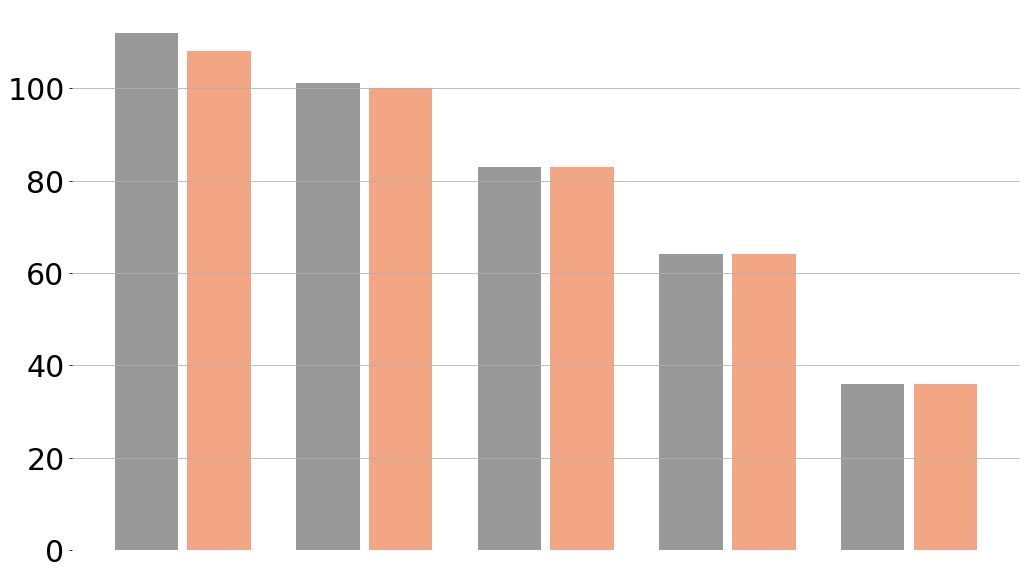

Pathway matrix  (11579, 1077)
P-values matrix  (150, 1077)
All final results 
[28.666666666666668, 32.57575757575758, 38.53211009174312, 23.809523809523807, 28.30188679245283]


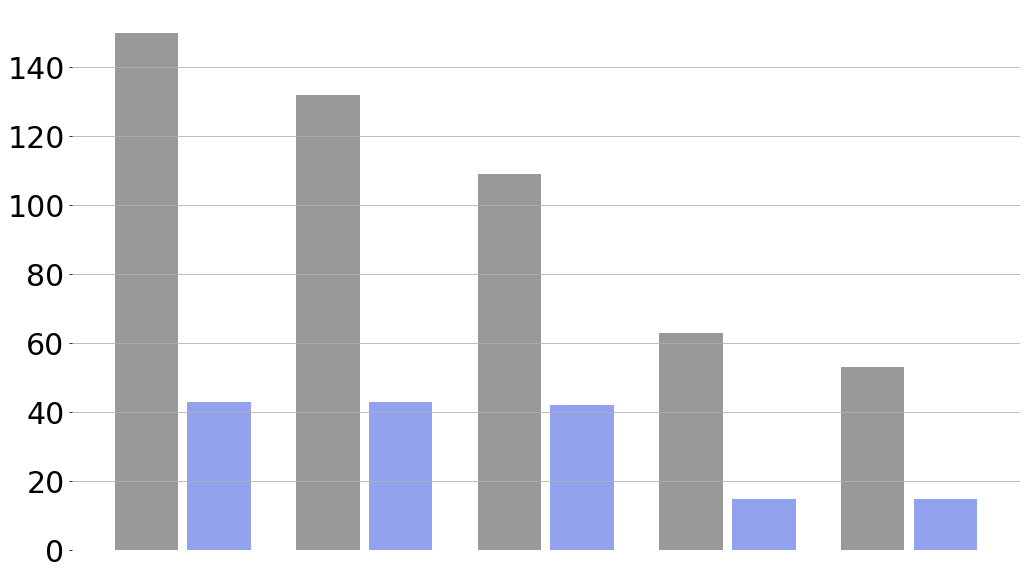

Pathway matrix  (10030, 1077)
P-values matrix  (150, 1077)
All final results 
[81.3953488372093, 86.27450980392157, 97.2972972972973, 100.0, 100.0]


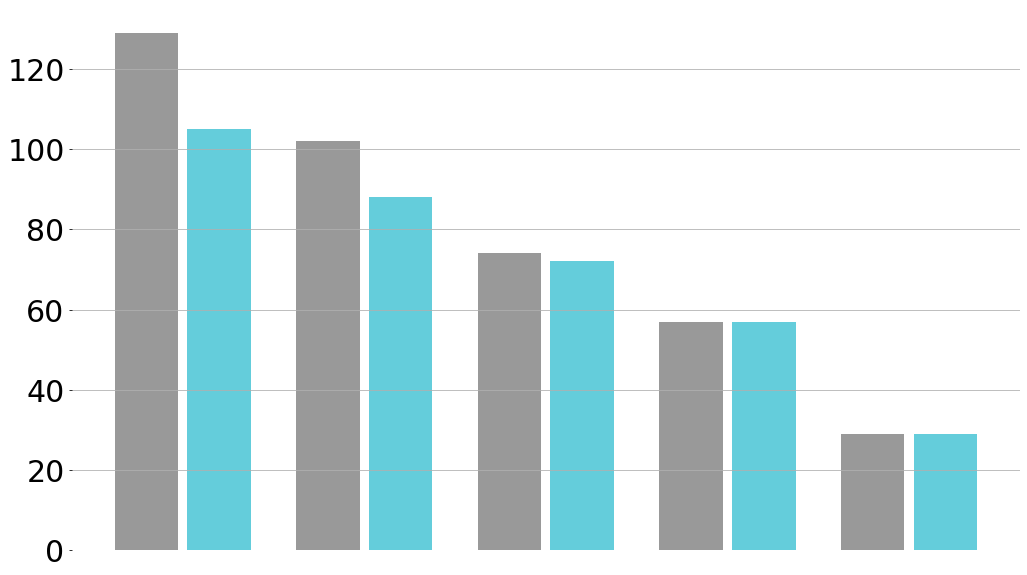

Pathway matrix  (10551, 1077)
P-values matrix  (150, 1077)
All final results 
[91.11111111111111, 96.58119658119658, 97.9381443298969, 100.0, 100.0]


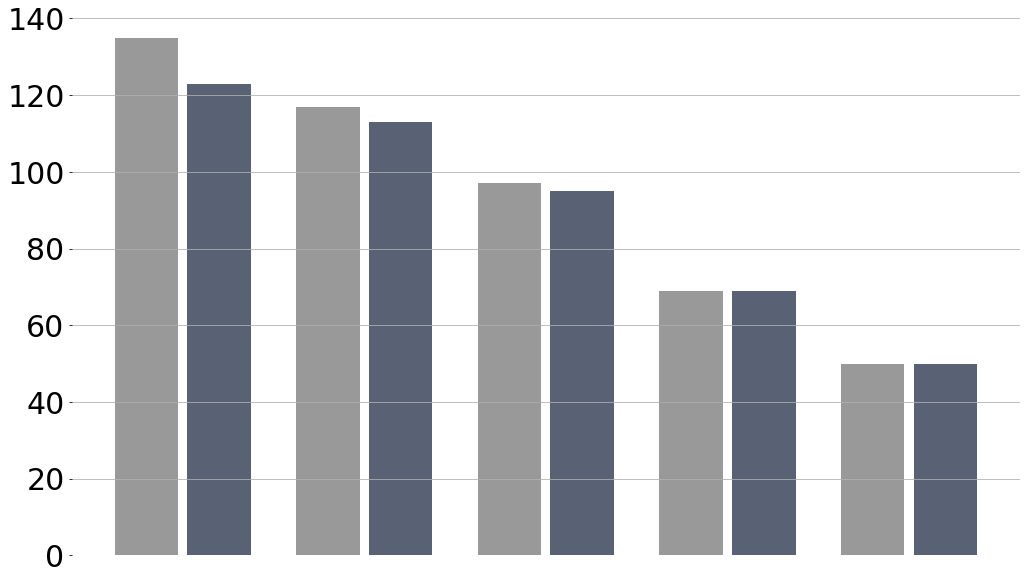

Pathway matrix  (7656, 1077)
P-values matrix  (150, 1077)
All final results 
[92.72727272727272, 94.5945945945946, 95.65217391304348, 100.0, 100.0]


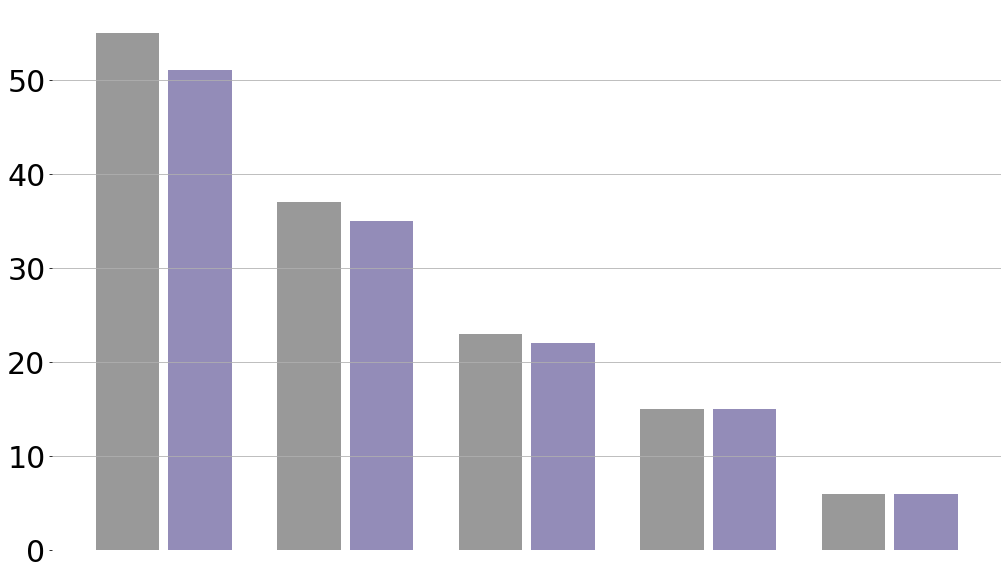

Pathway matrix  (10342, 1077)
P-values matrix  (150, 1077)
All final results 
[95.55555555555556, 98.30508474576271, 99.05660377358491, 100.0, 100.0]


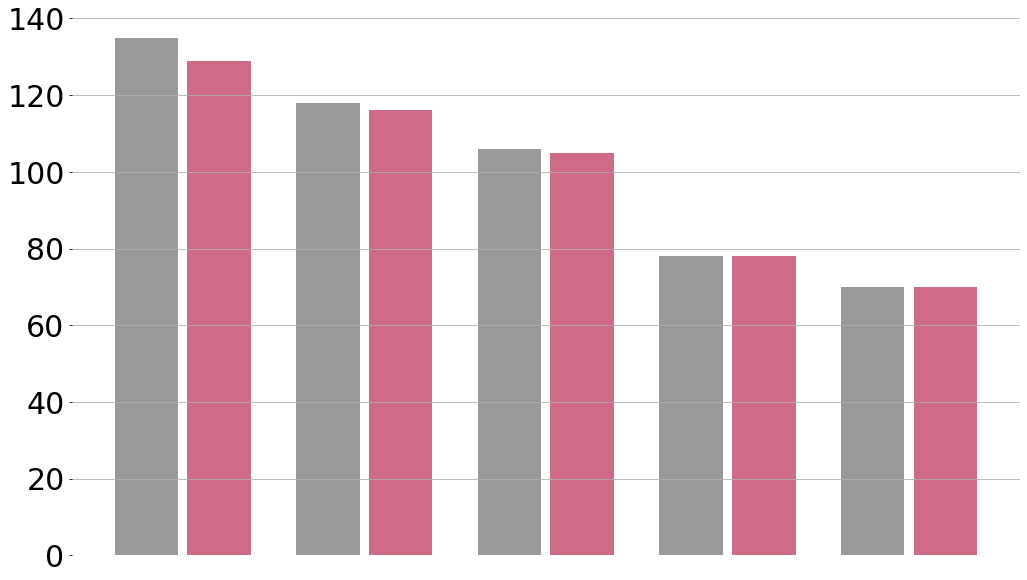

Pathway matrix  (9916, 1077)
P-values matrix  (150, 1077)
All final results 
[79.88165680473372, 91.53846153846153, 100.0, 100.0, 100.0]


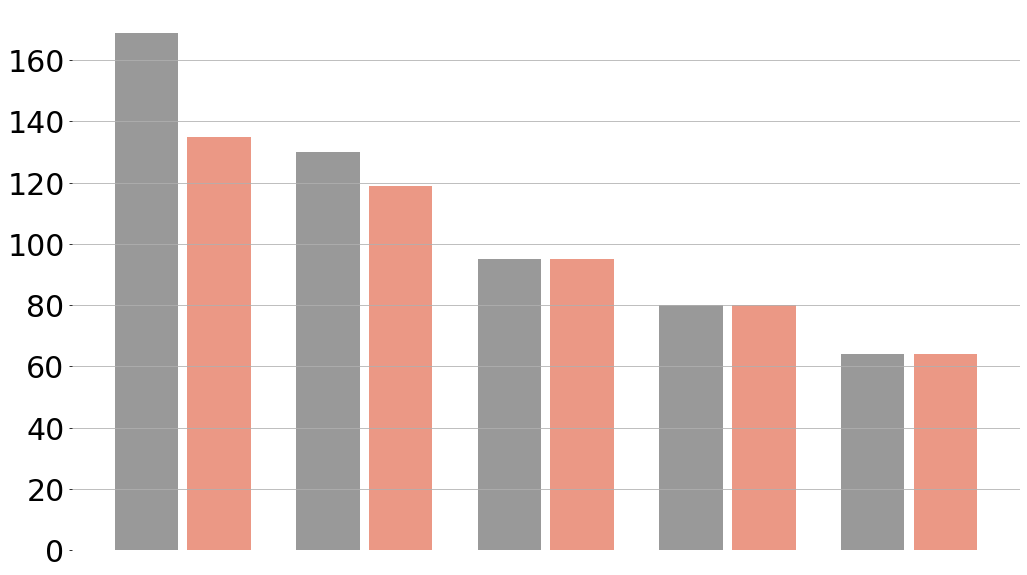

Pathway matrix  (12730, 1077)
P-values matrix  (150, 1077)
All final results 
[94.11764705882352, 97.2027972027972, 100.0, 100.0, 100.0]


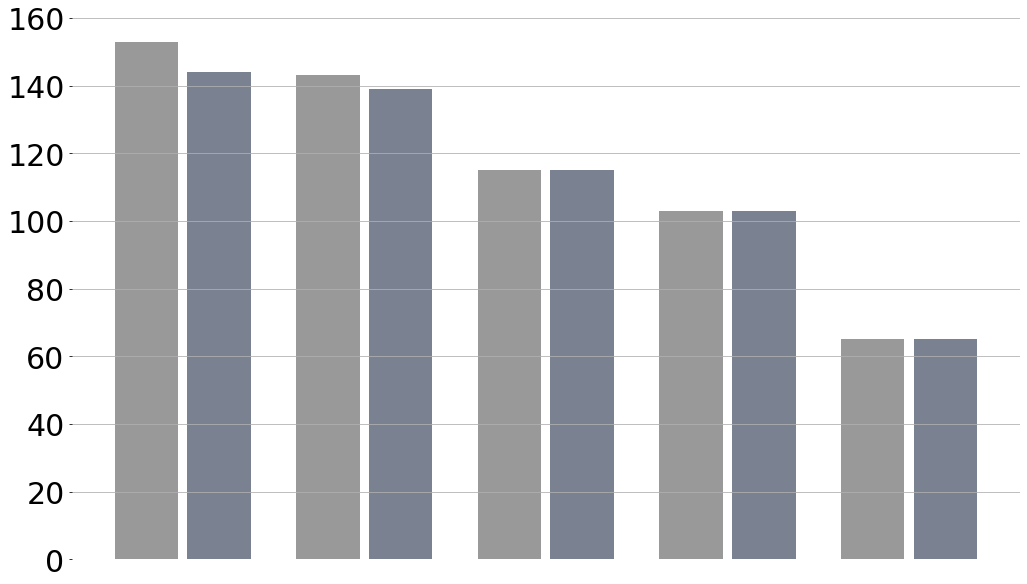

Pathway matrix  (13236, 1077)
P-values matrix  (150, 1077)
All final results 
[98.33333333333333, 99.0, 100.0, 100.0, 100.0]


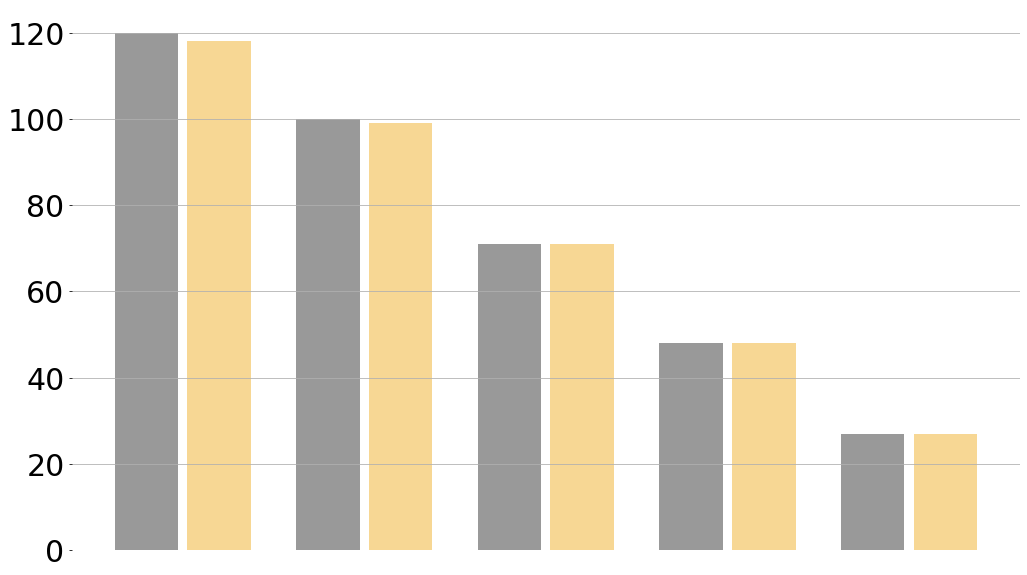

Pathway matrix  (12641, 1077)
P-values matrix  (150, 1077)
All final results 
[89.28571428571429, 93.75, 94.39252336448598, 100.0, 100.0]


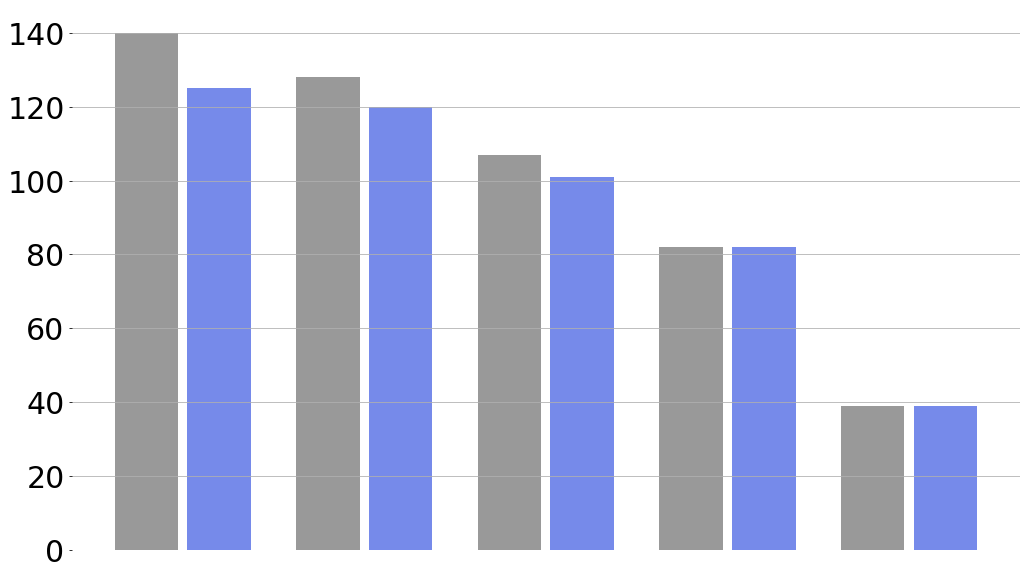

Pathway matrix  (12339, 1077)
P-values matrix  (150, 1077)
All final results 
[98.46153846153847, 100.0, 100.0, 100.0, 100.0]


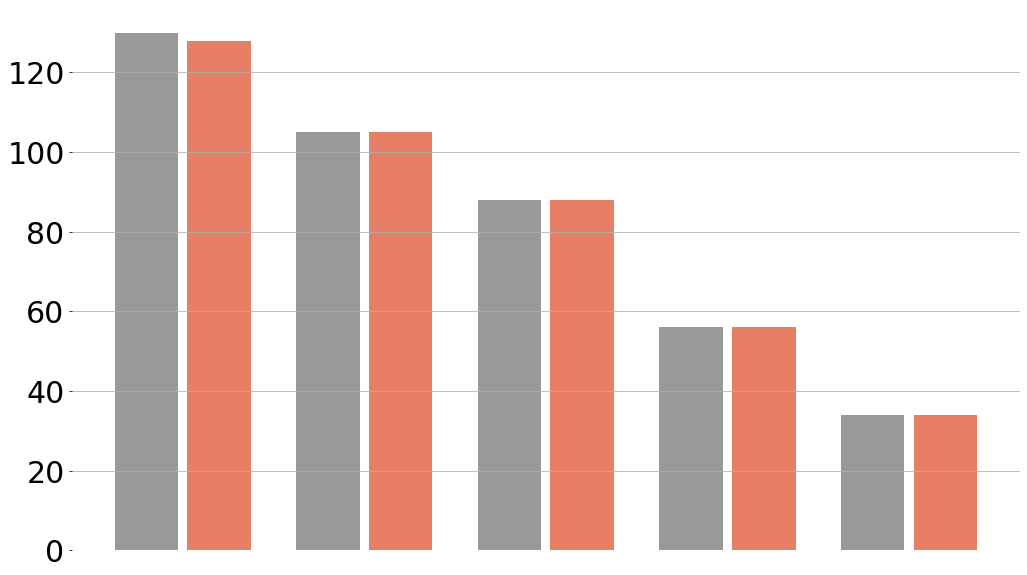

Pathway matrix  (11646, 1077)
P-values matrix  (150, 1077)
All final results 
[82.6086956521739, 90.0, 100.0, 100.0, 0]


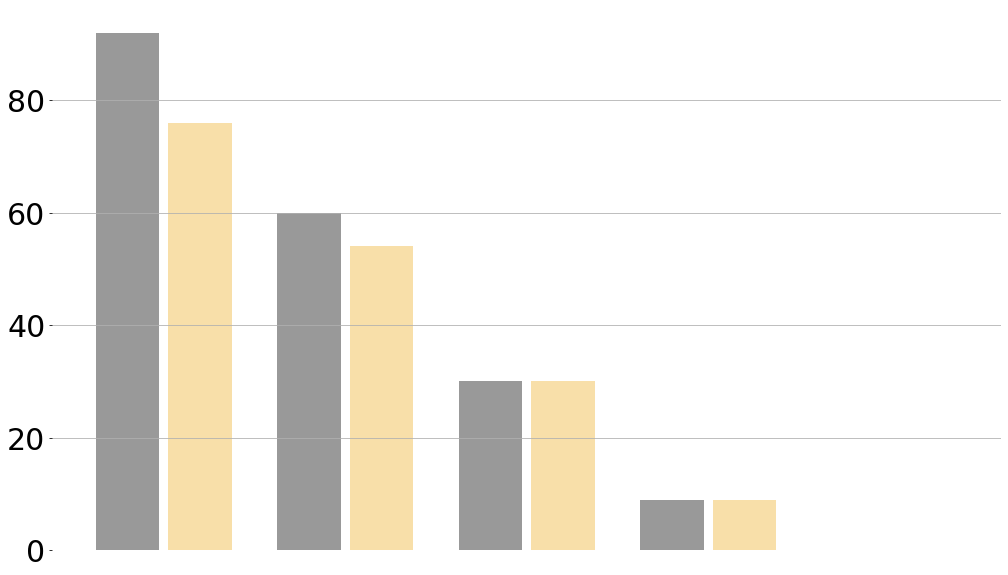

Pathway matrix  (13237, 1077)
P-values matrix  (150, 1077)
All final results 
[94.20289855072464, 98.0392156862745, 95.45454545454545, 100.0, 100.0]


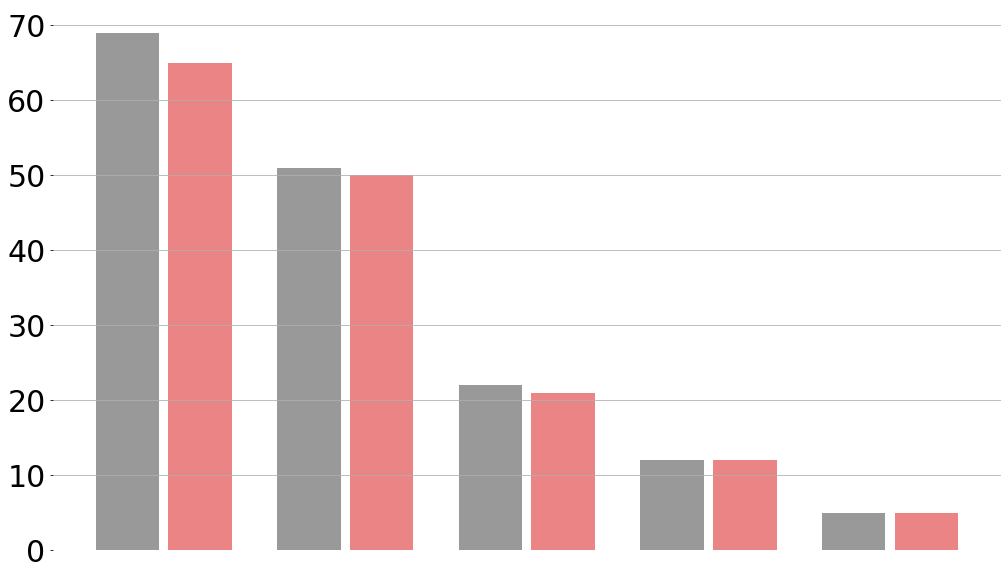

Pathway matrix  (13237, 1077)
P-values matrix  (150, 1077)
All final results 
[97.82608695652173, 98.47328244274809, 98.27586206896551, 100.0, 100.0]


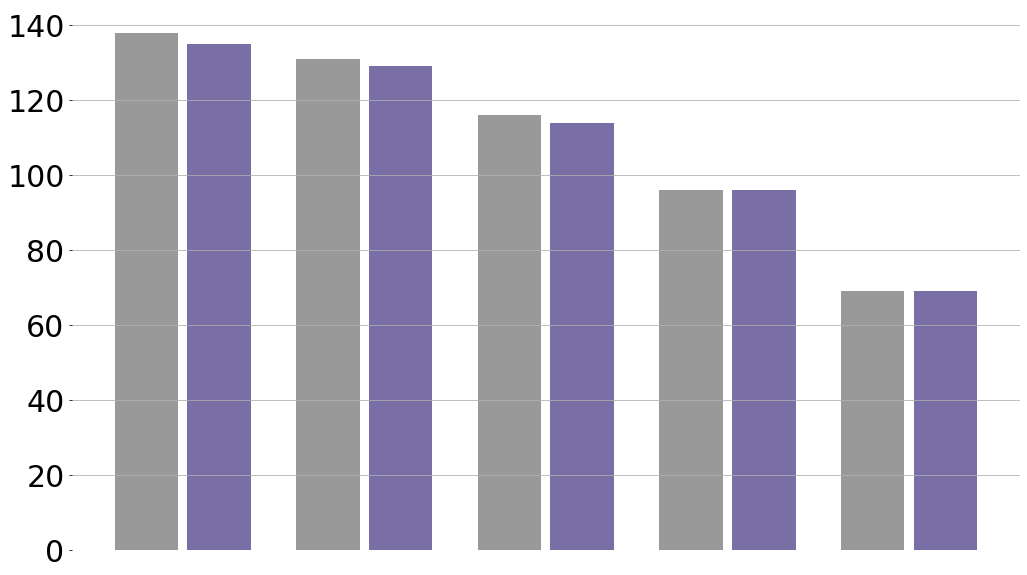

Pathway matrix  (11020, 1077)
P-values matrix  (150, 1077)
All final results 
[95.62841530054644, 98.72611464968153, 100.0, 100.0, 100.0]


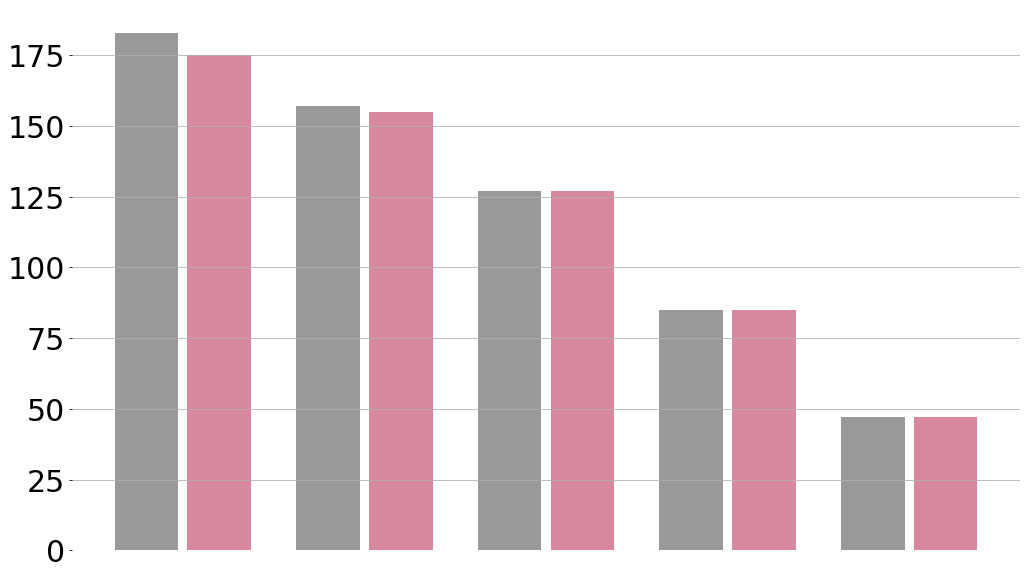

Pathway matrix  (4610, 1077)
P-values matrix  (150, 1077)
All final results 
[98.93617021276596, 98.83720930232558, 98.68421052631578, 100.0, 100.0]


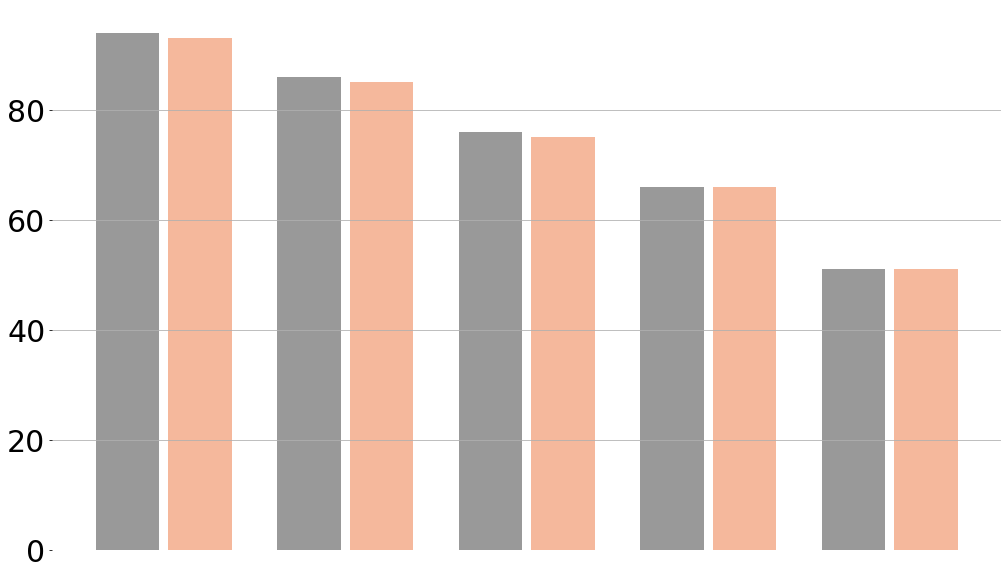

Pathway matrix  (13237, 1077)
P-values matrix  (150, 1077)
All final results 
[95.72649572649573, 95.18072289156626, 100.0, 100.0, 100.0]


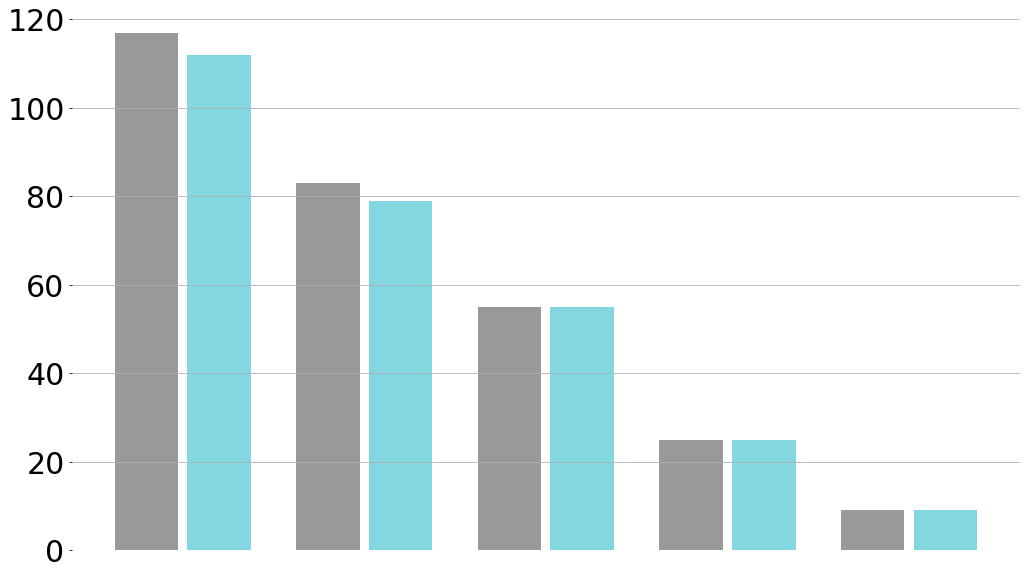

Pathway matrix  (13237, 1077)
P-values matrix  (150, 1077)
All final results 
[97.3404255319149, 98.78048780487805, 99.24812030075188, 100.0, 100.0]


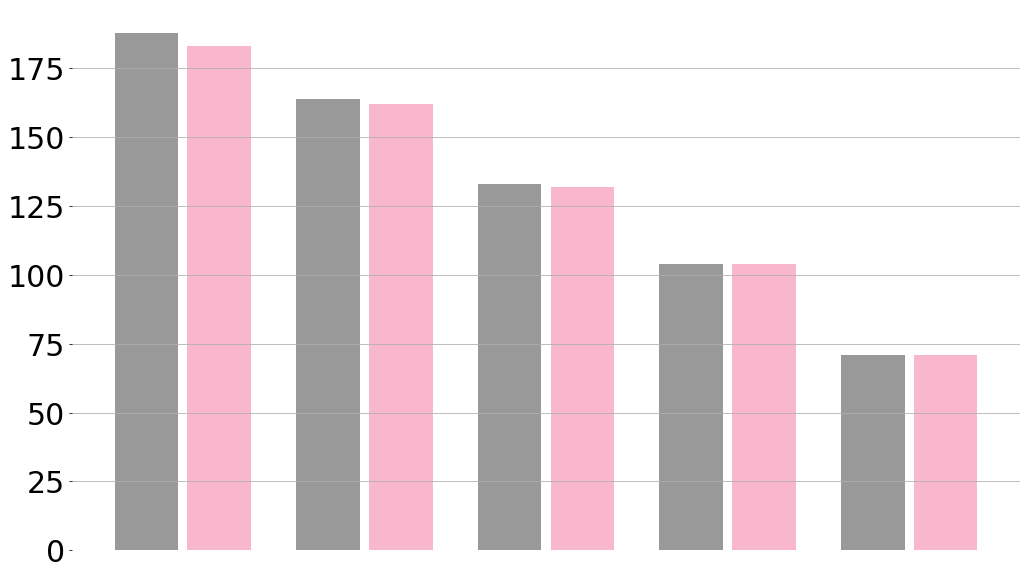

In [13]:
for cancer in cancer_types:
    createPlot(cancer)